In [13]:
import os
from contextlib import redirect_stdout
import numpy as np
import torch as T
import torch.nn as nn
from matplotlib import pyplot as plt
from datagenerator import makesignal, get_params_from_json
from model import UNet1SnC  # Ensure this matches the model used in training

In [10]:
# Devices and file paths
device = T.device("cuda" if T.cuda.is_available() else "mps" if T.backends.mps.is_available() else "cpu")
print("Using device:", device)

model_path = './savedmodels/modelFinal.pth'  # Path to the saved model
params_path = './Parameters/params.json'    # Path to the parameters file

Using device: mps


In [20]:
# Load model architecture and parameters
net = UNet1SnC(n_channels=1, n_classes=6)  # Ensure this matches the training model

net.load_state_dict(T.load(model_path, map_location=device, weights_only=True))

# Neater map that does not spew architecture
with open(os.devnull, 'w') as f, redirect_stdout(f):
    net.to(device)
    net.eval()  # Set the model to evaluation mode



In [21]:
# Load signal parameters and generate a test signal
params = get_params_from_json(params_path)
params['noise_level'] = 0.2  # Adjust noise level if needed

x_tmp, gt, signalclass = makesignal(params)  # Generate a test signal
x_tmp_exp = x_tmp[:, None]  # Add channel dimension
x = T.tensor(x_tmp_exp, dtype=T.float32).to(device)


In [22]:
# Run inference for dense segmentation
with T.no_grad():
    out, ws = net(x), None  # Adjust if `net` returns additional outputs

ShapeLikelihood = out[0].cpu().numpy().squeeze()  # Convert output to NumPy array


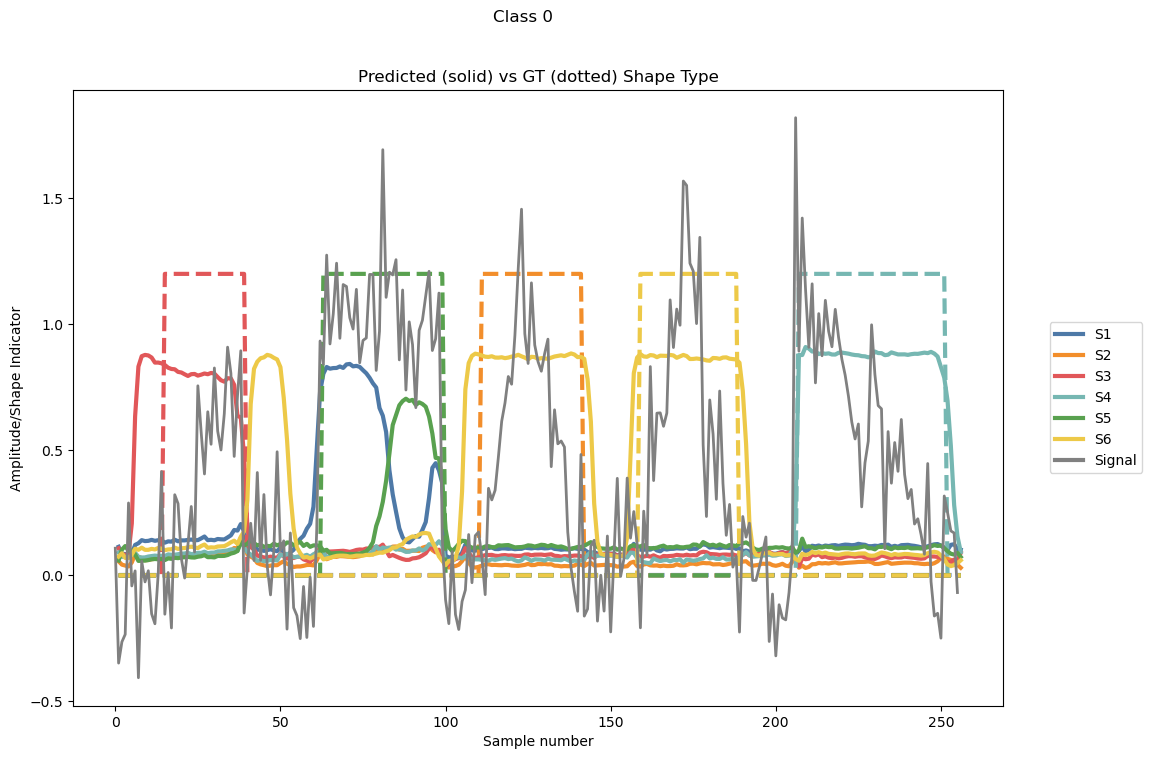

In [7]:
# Visualize the results
fig = plt.figure(figsize=(12, 8))
ax = plt.gca()

# Modern color palette (Tableau 10)
colours = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F', '#EDC948']

for i in range(ShapeLikelihood.shape[0]):
    plt.plot(np.arange(1, 257), 1.2 * gt[:, i], ls='--', lw=3, color=colours[i])  # Ground truth
    plt.plot(np.arange(1, 257), ShapeLikelihood[i, :], lw=3, color=colours[i])   # Predictions

plt.plot(x_tmp[0], ls='-', lw=2, color='#808080', label='Signal')

# Create a custom legend for the six classes
legend_handles = [plt.Line2D([0], [0], color=col, lw=3) for col in colours]
legend_handles.append(plt.Line2D([0], [0], color='#808080', lw=3))  # Add signal to legend
plt.legend(legend_handles, ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'Signal'], bbox_to_anchor=(1.1, 0.5), loc='center')

# Add labels and title
plt.xlabel('Sample number')
plt.ylabel('Amplitude/Shape Indicator')
plt.title('Predicted (solid) vs GT (dotted) Shape Type')
plt.suptitle('Class ' + str(signalclass))

# Save the plot
plt.savefig('./Figures/DenseSegmentationInference.svg')
plt.show()

## Evaluation Code Below Here
Below this line, we run some evaluations over trial runs using different noise levels. 

In [45]:
NTrials = 50
NNoiseLevels = 10
NoiseLevels = np.linspace(0.1,1.0,NNoiseLevels)

# Load signal parameters and generate a test signal
params = get_params_from_json(params_path)

# Initialize arrays to store results
woJACCI = np.zeros((NTrials,NNoiseLevels))
JI = np.zeros(10)

# Threshold for shape likelihood
Thresh = 0.25

for i in range(NTrials):
    for j in range(NNoiseLevels):

        params['noise_level'] = NoiseLevels[j]  # Adjust noise level

        x_tmp, gt, signalclass = makesignal(params)  # Generate a test signal
        x_tmp_exp = x_tmp[:, None]  # Add channel dimension
        x = T.tensor(x_tmp_exp, dtype=T.float32).to(device) 

        out = net(x)[0].detach().squeeze().cpu().numpy()

        ShapeLikelihood = np.transpose(out)

        ShapeLikelihoodThresholded = ShapeLikelihood>Thresh
        Intersection = np.logical_and(ShapeLikelihoodThresholded, gt)
        Union = np.logical_or(ShapeLikelihoodThresholded, gt)
        Jaccard = np.sum(Intersection)/np.sum(Union)
        woJACCI[i,j] = Jaccard



In [44]:
NTrials = 50
NNoiseLevels = 10
NoiseLevels = np.linspace(0.1,1.0,NNoiseLevels)

# Load signal parameters and generate a test signal
params = get_params_from_json(params_path)
params['with_replacement'] = True  # Replacement is enabled for comparison trials

# Initialize arrays to store results
wJACCI = np.zeros((NTrials,NNoiseLevels))
JI = np.zeros(10)

# Threshold for shape likelihood
Thresh = 0.25

for i in range(NTrials):
    for j in range(NNoiseLevels):

        params['noise_level'] = NoiseLevels[j]  # Adjust noise level

        x_tmp, gt, signalclass = makesignal(params)  # Generate a test signal
        x_tmp_exp = x_tmp[:, None]  # Add channel dimension
        x = T.tensor(x_tmp_exp, dtype=T.float32).to(device) 

        out = net(x)[0].detach().squeeze().cpu().numpy()

        ShapeLikelihood = np.transpose(out)

        ShapeLikelihoodThresholded = ShapeLikelihood>Thresh
        Intersection = np.logical_and(ShapeLikelihoodThresholded, gt)
        Union = np.logical_or(ShapeLikelihoodThresholded, gt)
        Jaccard = np.sum(Intersection)/np.sum(Union)
        wJACCI[i,j] = Jaccard



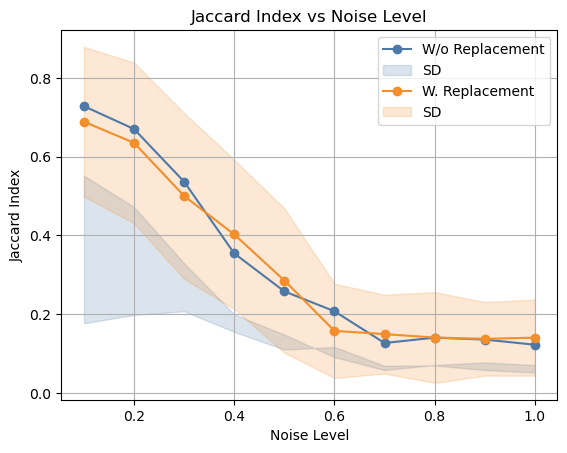

In [46]:
plt.plot(NoiseLevels, woJACCI.mean(axis=0), marker='o', color='#4E79A7', label='Mean Jaccard Index')
plt.fill_between(NoiseLevels, woJACCI.mean(axis=0) - woJACCI.std(axis=0), 
                 JACCI.mean(axis=0) + woJACCI.std(axis=0), color='#4E79A7', alpha=0.2)

plt.plot(NoiseLevels, wJACCI.mean(axis=0), marker='o', color='#F28E2B', label='Mean Jaccard Index')
plt.fill_between(NoiseLevels, wJACCI.mean(axis=0) - wJACCI.std(axis=0), 
                 wJACCI.mean(axis=0) + wJACCI.std(axis=0), color='#F28E2B', alpha=0.2)

plt.xlabel('Noise Level')
plt.ylabel('Jaccard Index')
plt.title('Jaccard Index vs Noise Level')
plt.legend(['W/o Replacement', 'SD', 'W. Replacement', 'SD'], loc='upper right')
plt.grid(True)